# Tutorial on Bayesian linear regression

**Alfredo Garbuno-Inigo**  
Phd student, University of Liverpool  
Institute for Risk and Uncertainty

In [1]:
%matplotlib inline
from pymc3 import *
import pymc3 as pm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Case study: Admittance to university. 


In [2]:
d = {'dept': ['A','A','B','B','C','C','D','D','E','E','F','F'], 
    'gender': ['male','female','male','female','male','female','male','female','male','female','male','female'], 
    'admit': [512,89,353,17,120,202,138,131,53,94,22,24], 
    'reject': [313,19, 207, 8,205,391 ,279, 244, 138 ,299, 351, 317], 
     'applications': [825,108,560,25,325,593,417,375,191,393,373,341]
    }
df = pd.DataFrame(d)

In [3]:
print 'Number of records: %s' %(df.shape[0])
print 'Number of features: %s' %(df.shape[1])

Number of records: 12
Number of features: 5


In [4]:
df.head(3)

,admit,applications,dept,gender,reject
0,512,825,A,male,313
1,89,108,A,female,19
2,353,560,B,male,207


In [5]:
dfsum = df.sum()[['admit','reject','applications']]
dfsum

admit           1755
reject          2771
applications    4526
dtype: object

# Case study: Admittance to university. 

In [6]:
print 'Acceptance rate: %s' %(np.ceil(100*(dfsum['admit']+0.0)/dfsum['applications']))

Acceptance rate: 39.0


In [7]:
df.groupby('gender').sum().apply(lambda x: (100*x['admit']+0.)/x['applications'], axis=1)

gender
female    30.354223
male      44.518766
dtype: float64

In [8]:
df.groupby('dept').sum()[['admit','reject', 'applications']]

,admit,reject,applications
dept,,,
A,601,332,933
B,370,215,585
C,322,596,918
D,269,523,792
E,147,437,584
F,46,668,714


In [9]:
df.groupby('dept').sum().apply(lambda x: 100.0*x[['admit','reject']]/x['applications'],axis=1)

,admit,reject
dept,,
A,64.415863,35.584137
B,63.247863,36.752137
C,35.076253,64.923747
D,33.964646,66.035354
E,25.171233,74.828767
F,6.442577,93.557423


In [10]:
depts = df.dept.unique()
n_depts = len(depts)
dept_table = dict(zip(depts, range(n_depts)))
dept = df.dept.replace(dept_table).values

dept_table

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5}

In [11]:
gender = df.gender.replace(dict(zip(df.gender.unique(), range(2))))

dict(zip(df.gender.unique(), range(2)))

{'female': 1, 'male': 0}

## Pooled model

$$ \begin{align}
A_i & \sim \text{Binomial}(n_i, p_i) \\
\text{logit}(p_i) & = \alpha + \beta \, m_i \\
\beta & \sim \mathcal{N}(0,1) \\
\alpha & \sim \mathcal{N}(0,1)
\end{align}
$$ 

In [12]:
with Model() as pooled_model:
    # Priors in regression coefficients
    beta = Normal('beta', 0, sd=1e1, shape=2)
    # Linear model
    theta = beta[0] + beta[1]*gender

    # This just computes the link function, no posterior sampling
    # p = pm.invlogit(theta)
    
    # To get posterior samples set as a deterministic transformation
    p = pm.Deterministic('p', pm.invlogit(theta))
    
    y = Binomial('y', n = df.applications, p = p, observed = df.admit)

In [13]:
n_samples = 3000
n_opt = 20000
n_warm = 1000

with pooled_model:
    pooled_trace = sample(n_samples, n_init=n_opt, tune=n_warm, njobs = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 454.33:  47%|████▋     | 9422/20000 [00:01<00:01, 7390.57it/s]
Convergence archived at 10000
Interrupted at 10,000 [50%]: Average Loss = 557.58
100%|██████████| 4000/4000 [00:07<00:00, 548.47it/s]


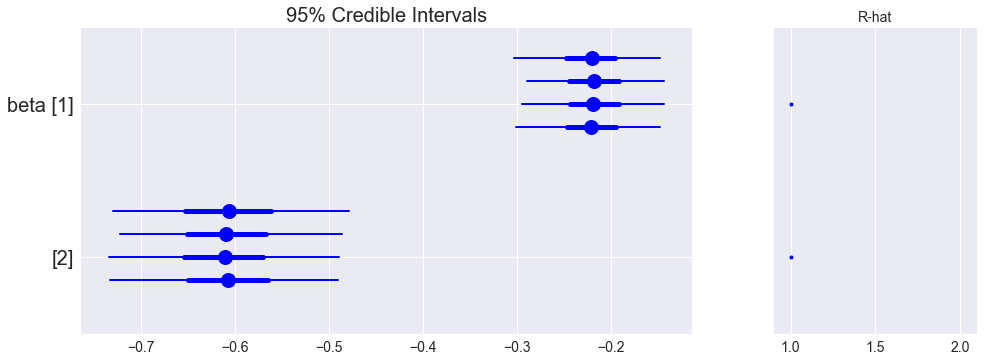

In [78]:
plt.figure(figsize=(15, 5))
forestplot(pooled_trace[n_warm:], varnames = ['beta'], fontsize = 20, linewidth = 5, marker = 'o', markersize = 15, chain_spacing = .15);

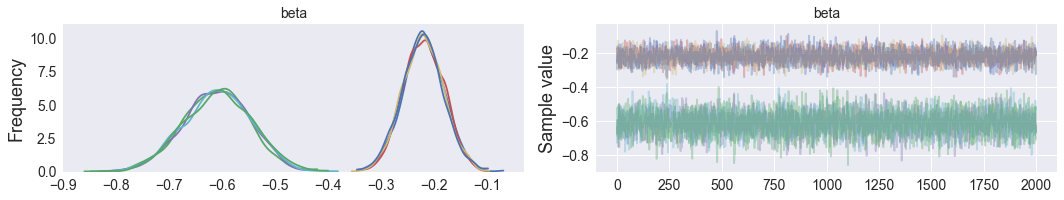

In [77]:
pm.traceplot(pooled_trace[1000:], varnames = ['beta'], figsize=(15, 3));

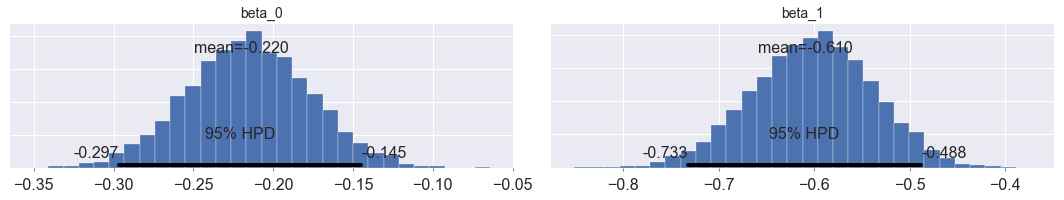

In [76]:
pm.plot_posterior(pooled_trace[1000:], varnames = ['beta'], figsize=(15, 3));

In [32]:
dfsort = df.sort_values(['dept','gender'],ascending=[True, False])
pobs = 1.*dfsort['admit']/dfsort['applications']

phat = pd.Series(pooled_trace[n_warm:]['p'].mean(axis = 0))
pstd = np.sqrt(phat*(1 - phat)/dfsort.applications)

In [37]:
x_loc = [1.5, 3.5, 5.5, 7.5, 9.5]

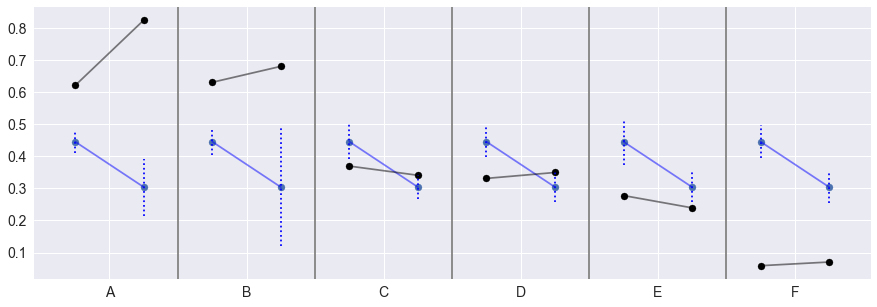

In [80]:
plt.figure(figsize=(15, 5)); plt.scatter(range(len(phat)), phat); plt.scatter(range(len(phat)), pobs, c='k')
for i, m, se in zip(range(len(phat)), phat, pstd):
    plt.plot([i,i], [m-2*se, m+2*se], 'b:')
for i in range(0,len(phat)-1,2):
    plt.plot([i,i+1], [phat[i], phat[i+1]], 'b', alpha = .5)
for i in range(0,len(phat)-1,2):
    plt.plot([i,i+1], [pobs[i], pobs[i+1]], 'k', alpha = .5)
for xc in x_loc: plt.axvline(x=xc, color = 'gray')
plt.xticks(np.arange(0,12,2)+.5, df.dept.unique());



## Unpooled model

$$ \begin{align}
\begin{array}{rlr}
A_i & \sim \text{Binomial}(n_i, p_i) \\
\text{logit}(p_i) & = \alpha_{\text{DEPT}[i]} + \beta \, m_i \\
\beta & \sim \mathcal{N}(0,1) \\
\alpha_{\text{DEPT}} & \sim \mathcal{N}(0,1) & \forall \text{ DEPT} \in \{A, \ldots, F\}\\
\end{array}
\end{align}
$$ 

In [81]:
with Model() as funpooled_model:
    # Priors in regression coefficients
    beta = Normal('beta', 0, sd=1e1, shape=n_depts)
    alpha = Normal('alpha', 0, sd = 1e1, shape=n_depts)
    # Linear model
    theta = alpha[dept] + beta[dept] * gender
    
    # To get posterior samples set as a deterministic transformation
    p = pm.Deterministic('p', pm.invlogit(theta))
    
    y = Binomial('y', n = df.applications, p = p, observed = df.admit)

In [82]:
with funpooled_model:
    funpooled_trace = sample(n_samples, n_init=n_opt, tune=n_warm, njobs = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 89.133:  69%|██████▉   | 13780/20000 [00:02<00:00, 6400.32it/s]
Convergence archived at 14100
Interrupted at 14,100 [70%]: Average Loss = 222.89
100%|██████████| 4000/4000 [00:18<00:00, 220.16it/s]


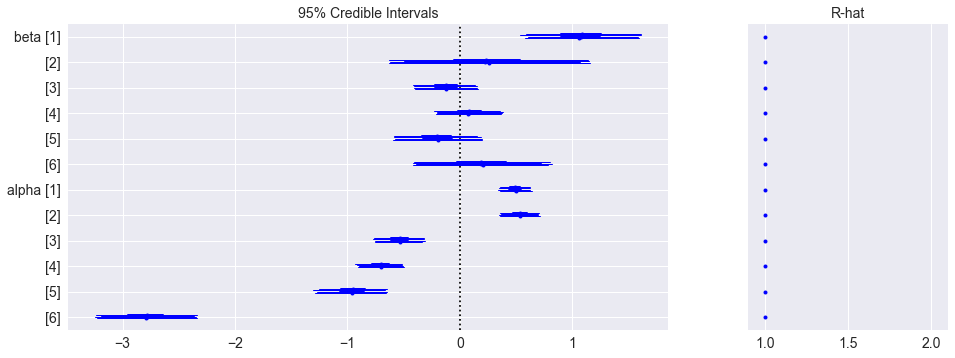

In [86]:
plt.figure(figsize=(15, 5))
forestplot(funpooled_trace[1000:], varnames = ['beta', 'alpha']);

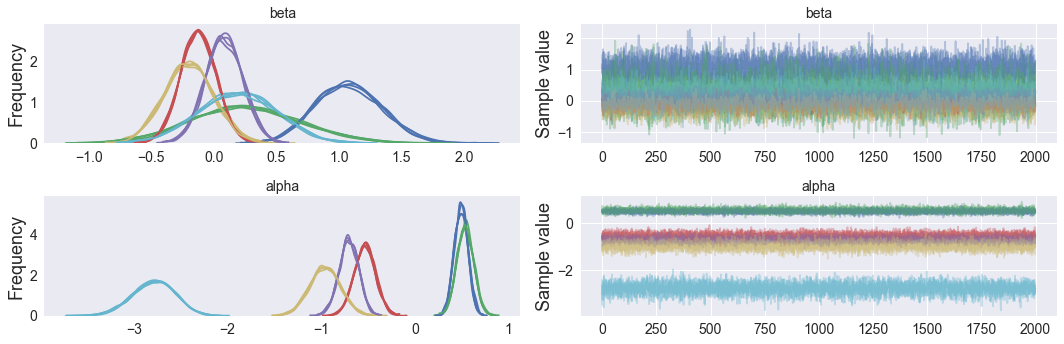

In [89]:
pm.traceplot(funpooled_trace[n_warm:], varnames = ['beta', 'alpha'], figsize=(15, 5));

In [90]:
phat_funpooled = pd.Series(funpooled_trace[n_warm:]['p'].mean(axis = 0))
pstd_funpooled = np.sqrt(phat_funpooled*(1 - phat_funpooled)/dfsort.applications)

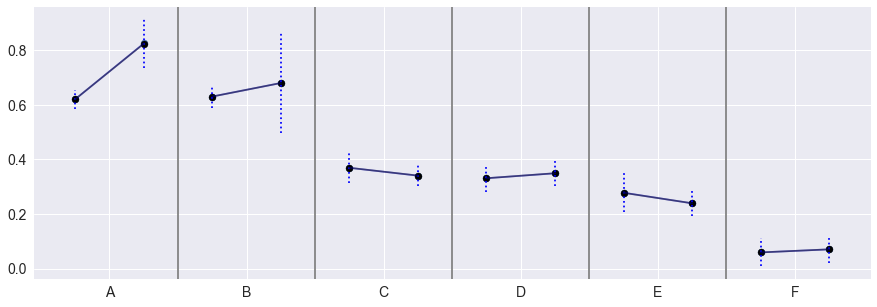

In [91]:
plt.figure(figsize=(15, 5)); plt.scatter(range(len(phat)), phat_funpooled); plt.scatter(range(len(phat)), pobs, c='k')
for i, m, se in zip(range(len(phat)), phat_funpooled, pstd):
    plt.plot([i,i], [m-2*se, m+2*se], 'b:')
for i in range(0,len(phat)-1,2):
    plt.plot([i,i+1], [phat_funpooled[i], phat_funpooled[i+1]], 'b', alpha = .5)
for i in range(0,len(phat)-1,2):
    plt.plot([i,i+1], [pobs[i], pobs[i+1]], 'k', alpha = .5)
for xc in x_loc: plt.axvline(x=xc, color = 'gray')
plt.xticks(np.arange(0,12,2)+.5, df.dept.unique());

## Unpooled model

$$ \begin{align}
\begin{array}{rlr}
A_i & \sim \text{Binomial}(n_i, p_i) \\
\text{logit}(p_i) & = \alpha_{\text{DEPT}[i]} + \beta \, m_i \\
\beta & \sim \mathcal{N}(0,1) \\
\alpha_{\text{DEPT}} & \sim \mathcal{N}(0,1) & \forall \text{ DEPT} \in \{A, \ldots, F\}\\
\end{array}
\end{align}
$$ 

In [92]:
with Model() as unpooled_model:
    # Priors in regression coefficients
    beta = Normal('beta', 0, sd=1e0)
    alpha = Normal('alpha', 0, sd = 1e0, shape=n_depts)
    # Linear model
    theta = alpha[dept] + beta * gender
    
    # To get posterior samples set as a deterministic transformation
    p = pm.Deterministic('p', pm.invlogit(theta))
    
    y = Binomial('y', n = df.applications, p = p, observed = df.admit)

In [93]:
with unpooled_model:
    unpooled_trace = sample(n_samples, n_init=n_opt, tune=n_warm, njobs = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 69.903:  62%|██████▏   | 12402/20000 [00:01<00:01, 6558.69it/s]
Convergence archived at 12700
Interrupted at 12,700 [63%]: Average Loss = 227.14
100%|██████████| 4000/4000 [00:12<00:00, 319.14it/s]


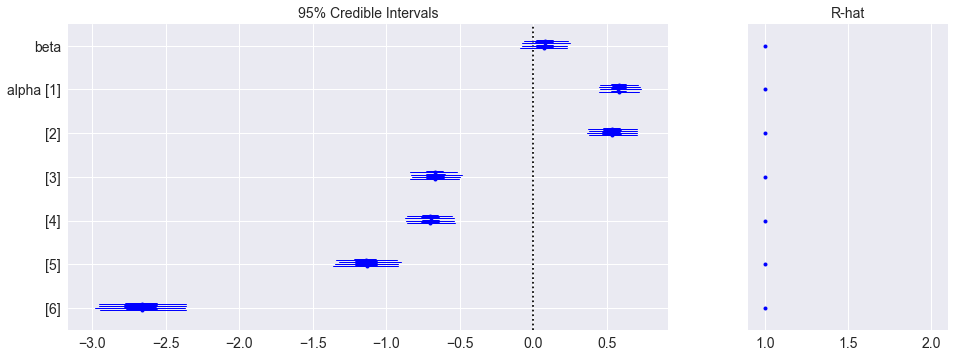

In [94]:
plt.figure(figsize=(15, 5))
forestplot(unpooled_trace[1000:], varnames = ['beta', 'alpha']);

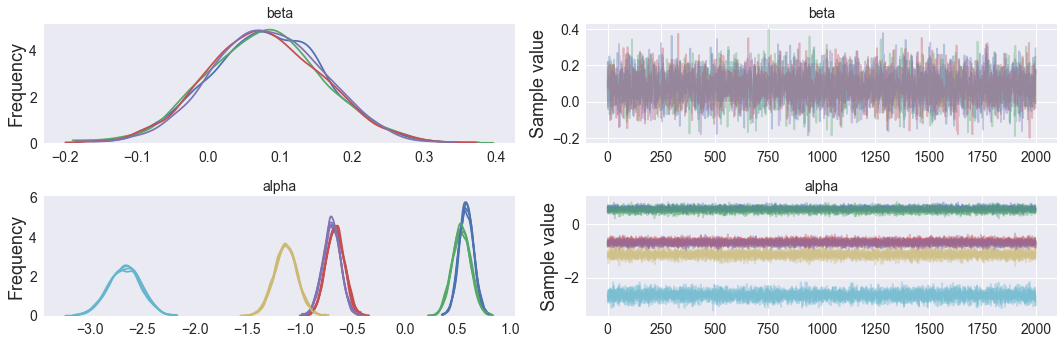

In [100]:
pm.traceplot(unpooled_trace[1000:], varnames = ['beta', 'alpha'], figsize = (15, 5));

In [101]:
phat_unpooled = pd.Series(unpooled_trace[n_warm:]['p'].mean(axis = 0))
pstd_unpooled = np.sqrt(phat_unpooled*(1 - phat_unpooled)/dfsort.applications)

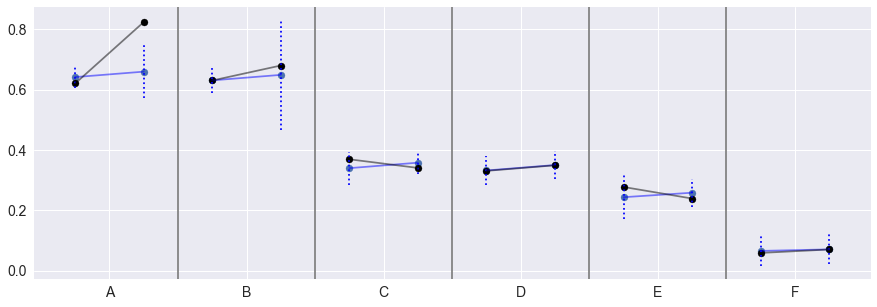

In [102]:
plt.figure(figsize=(15, 5)); plt.scatter(range(len(phat)), phat_unpooled); plt.scatter(range(len(phat)), pobs, c='k')
for i, m, se in zip(range(len(phat)), phat_unpooled, pstd):
    plt.plot([i,i], [m-2*se, m+2*se], 'b:')
for i in range(0,len(phat)-1,2):
    plt.plot([i,i+1], [phat_unpooled[i], phat_unpooled[i+1]], 'b', alpha = .5)
for i in range(0,len(phat)-1,2):
    plt.plot([i,i+1], [pobs[i], pobs[i+1]], 'k', alpha = .5)
for xc in x_loc: plt.axvline(x=xc, color = 'gray')
plt.xticks(np.arange(0,12,2)+.5, df.dept.unique());

## Hierarchical: *varying intercept*

$$ \begin{align}
\begin{array}{rlr}
A_i & \sim \text{Binomial}(n_i, p_i) \\
\text{logit}(p_i) & = \alpha_{\text{DEPT}[i]} + \beta \, m_i \\
\beta & \sim \mathcal{N}(0,1) \\
\alpha_{\text{DEPT}} & \sim \mathcal{N}(\mu_a,\sigma_a) & \forall \text{ DEPT} \in \{A, \ldots, F\}\\  
\mu_a & \sim \mathcal{N}(0,10) \\
\sigma_a & \sim \text{HalfCauchy}(0,2)
\end{array}
\end{align}
$$ 

In [103]:
with Model() as hierarchical:
    # Priors in highest hierarchy
    mu_a = Normal('mu_a', mu=0., sd=1e1)
    sigma_a = HalfCauchy('sigma_a', 5)
    
    # Priors in regression coefficients
    beta = Normal('beta', 0, sd=1e0)
    alpha = Normal('alpha', mu_a, sd = sigma_a, shape=n_depts)
    
    # To get posterior samples set as a deterministic transformation
    theta = alpha[dept] + beta * gender
    p = pm.Deterministic('p', pm.invlogit(theta))
    y = Binomial('y', n = df.applications, p = p, observed = df.admit)

In [104]:
with hierarchical:
    hierarchical_trace = sample(n_samples, n_init=n_opt, tune=n_warm, njobs = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 72.3:  69%|██████▉   | 13836/20000 [00:02<00:01, 4939.88it/s]  
Convergence archived at 14000
Interrupted at 14,000 [70%]: Average Loss = 218.32
100%|██████████| 4000/4000 [00:13<00:00, 295.52it/s]


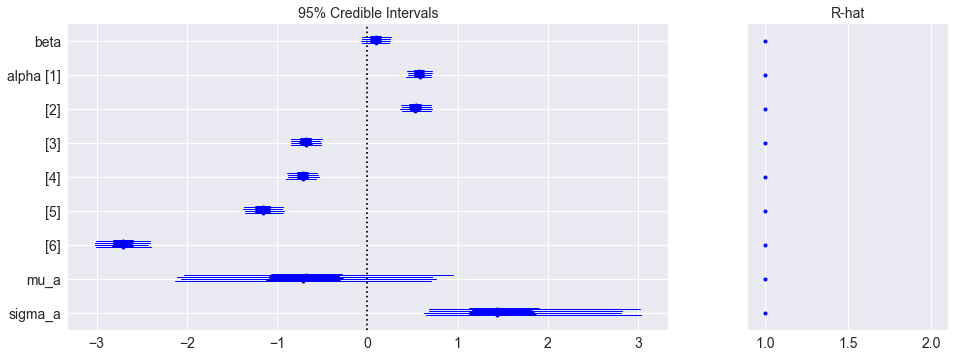

In [107]:
_ = plt.figure(figsize=(15, 5))
forestplot(hierarchical_trace[1000:], varnames = ['beta', 'alpha', 'mu_a', 'sigma_a']);

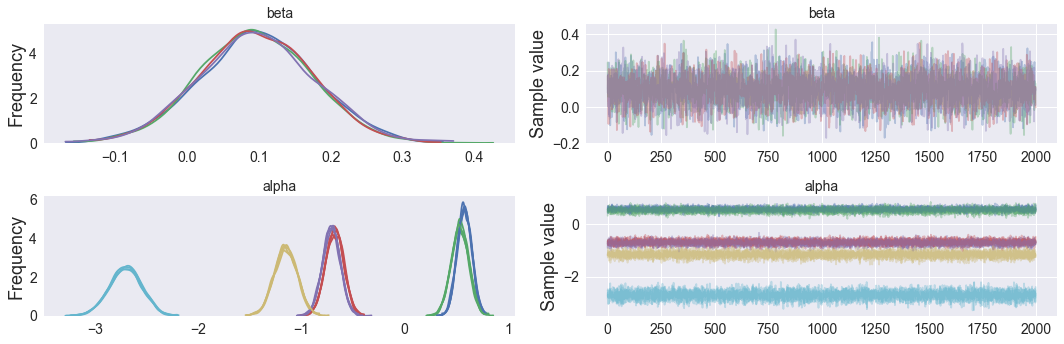

In [110]:
pm.traceplot(hierarchical_trace[1000:], varnames = ['beta', 'alpha'], figsize =(15,5));

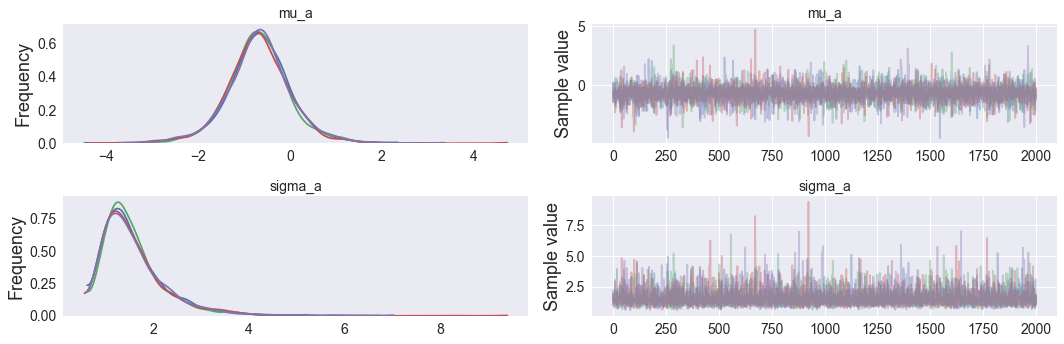

In [112]:
pm.traceplot(hierarchical_trace[1000:], varnames = ['mu_a', 'sigma_a'], figsize = (15,5));

In [113]:
phat_hierarchical = pd.Series(hierarchical_trace[n_warm:]['p'].mean(axis = 0))
pstd_hierarchical = np.sqrt(phat_hierarchical*(1 - phat_hierarchical)/dfsort.applications)

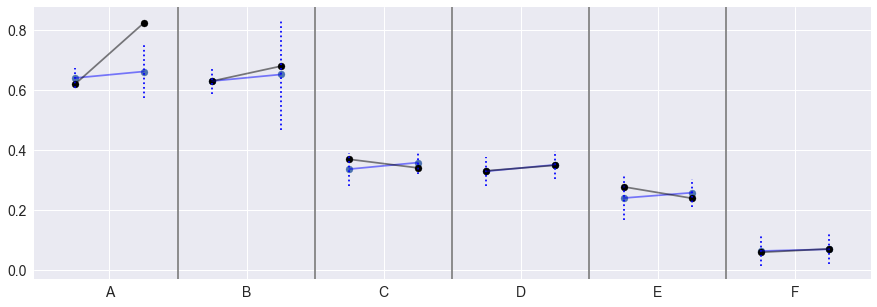

In [114]:
plt.figure(figsize=(15, 5)); plt.scatter(range(len(phat)), phat_hierarchical); plt.scatter(range(len(phat)), pobs, c='k')
for i, m, se in zip(range(len(phat)), phat_hierarchical, pstd):
    plt.plot([i,i], [m-2*se, m+2*se], 'b:')
for i in range(0,len(phat)-1,2):
    plt.plot([i,i+1], [phat_hierarchical[i], phat_hierarchical[i+1]], 'b', alpha = .5)
for i in range(0,len(phat)-1,2):
    plt.plot([i,i+1], [pobs[i], pobs[i+1]], 'k', alpha = .5)
for xc in x_loc: plt.axvline(x=xc, color = 'gray')
plt.xticks(np.arange(0,12,2)+.5, df.dept.unique());

## Full hierarchical: *Varying slope and intercept*

$$ \begin{align}
\begin{array}{rlr}
A_i & \sim \text{Binomial}(n_i, p_i) \\
\text{logit}(p_i) & = \alpha_{\text{DEPT}[i]} + \beta_{\text{DEPT}[i]} \, m_i \\
\beta_{\text{DEPT}} & \sim \mathcal{N}(\mu_b,\sigma_b) & \forall \text{ DEPT} \in \{A, \ldots, F\}\\  
\alpha_{\text{DEPT}} & \sim \mathcal{N}(\mu_a,\sigma_a) & \forall \text{ DEPT} \in \{A, \ldots, F\}\\  
\mu_a & \sim \mathcal{N}(0,10) \\
\mu_b & \sim \mathcal{N}(0,10) \\
\sigma_a & \sim \text{HalfCauchy}(0,2)\\
\sigma_b & \sim \text{HalfCauchy}(0,2)
\end{array}
\end{align}
$$ 

In [115]:
with Model() as full_hierarchical:
    # Priors in highest hierarchy
    mu_a = Normal('mu_a', mu=0., sd=1e1)
    sigma_a = HalfCauchy('sigma_a', 5)
    mu_b = Normal('mu_b', mu=0., sd=1e1)
    sigma_b = HalfCauchy('sigma_b', 5)
    
    # Priors in regression coefficients
    beta = Normal('beta', mu_b, sd=sigma_b, shape = n_depts)
    alpha = Normal('alpha', mu_a, sd = sigma_a, shape=n_depts)
    
    # To get posterior samples set as a deterministic transformation
    theta = alpha[dept] + beta[dept] * gender
    p = pm.Deterministic('p', pm.invlogit(theta))  
    y = Binomial('y', n = df.applications, p = p, observed = df.admit)

In [116]:
n_samples = 5000
n_warm = 2000

with full_hierarchical:
    full_hierarchical_trace = sample(n_samples, n_init=n_opt, tune=n_warm, njobs = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 76.077:  71%|███████   | 14118/20000 [00:03<00:01, 4004.14it/s]
Convergence archived at 14300
Interrupted at 14,300 [71%]: Average Loss = 210.65
100%|█████████▉| 6990/7000 [00:45<00:00, 168.16it/s]/Users/alfredogarbuno/anaconda2/envs/py2/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py:473: UserWarning: Chain 0 contains 40 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 7000/7000 [00:45<00:00, 153.58it/s]
/Users/alfredogarbuno/anaconda2/envs/py2/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py:473: UserWarning: Chain 1 contains 5 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
/Users/alfredogarbuno/anaconda2/envs/py2/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py:473: UserWarning: 

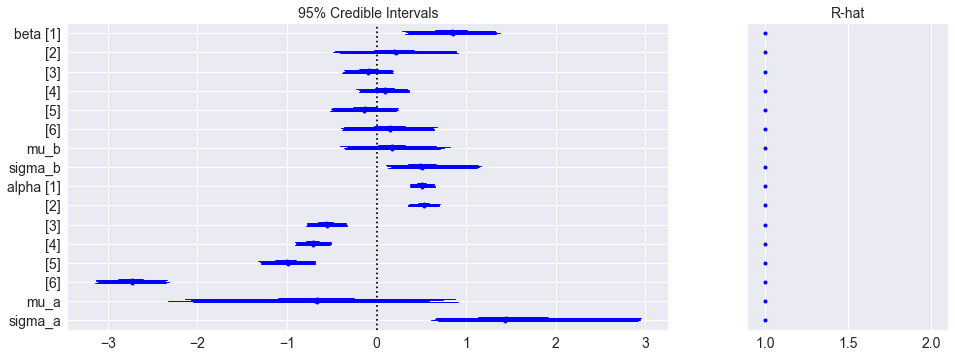

In [124]:
_ = plt.figure(figsize=(15, 5)); 
forestplot(full_hierarchical_trace[n_warm:], varnames = ['beta', 'mu_b','sigma_b','alpha', 'mu_a', 'sigma_a']);

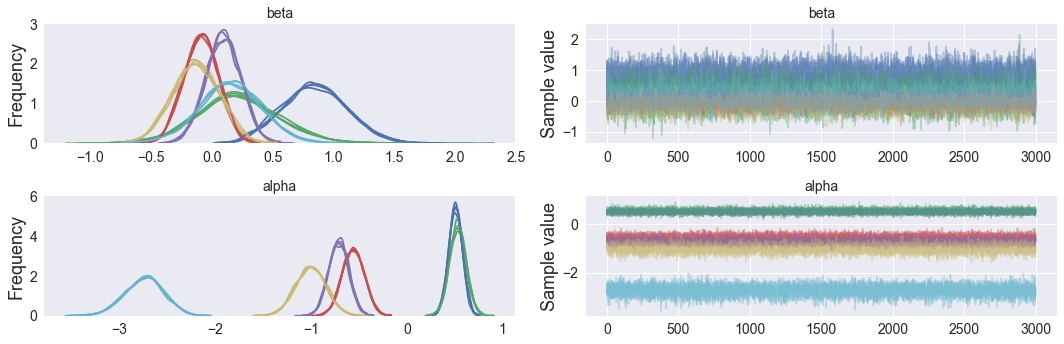

In [119]:
traceplot(full_hierarchical_trace[n_warm:], varnames = ['beta', 'alpha'], figsize=(15, 5)); 

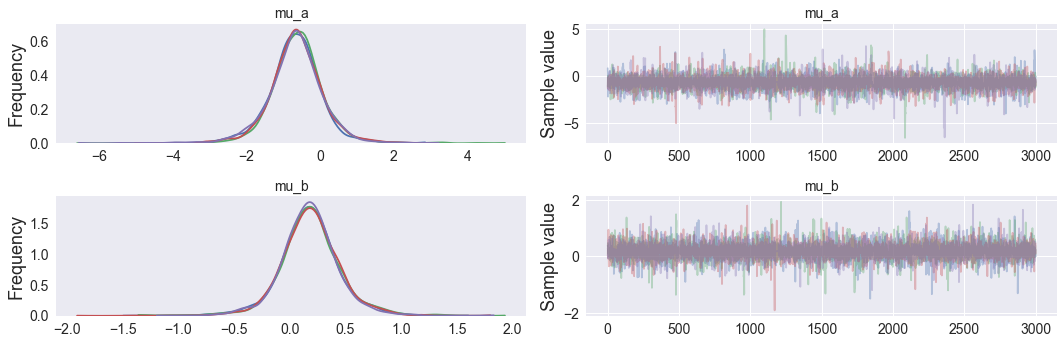

In [120]:
traceplot(full_hierarchical_trace[n_warm:], varnames = ['mu_a', 'mu_b'], figsize=(15, 5)); 

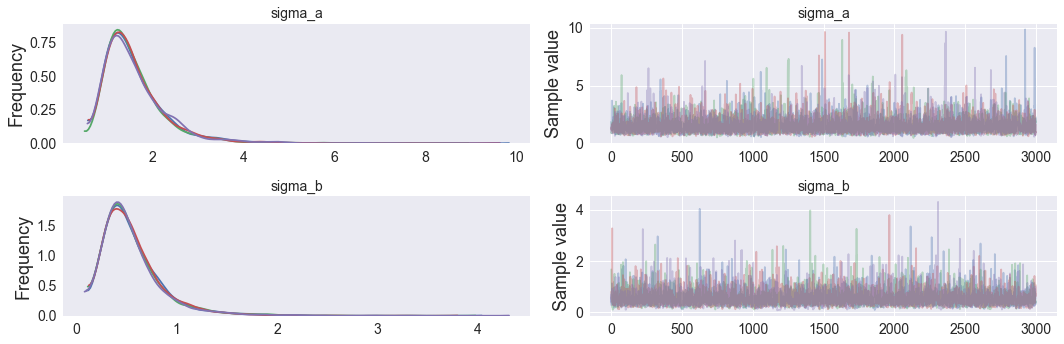

In [122]:
traceplot(full_hierarchical_trace[n_warm:], varnames = ['sigma_a', 'sigma_b'], figsize=(15, 5));

In [125]:
phat_fhierarchical = pd.Series(full_hierarchical_trace[n_warm:]['p'].mean(axis = 0))
pstd_fhierarchical = np.sqrt(phat_fhierarchical*(1 - phat_fhierarchical)/dfsort.applications)

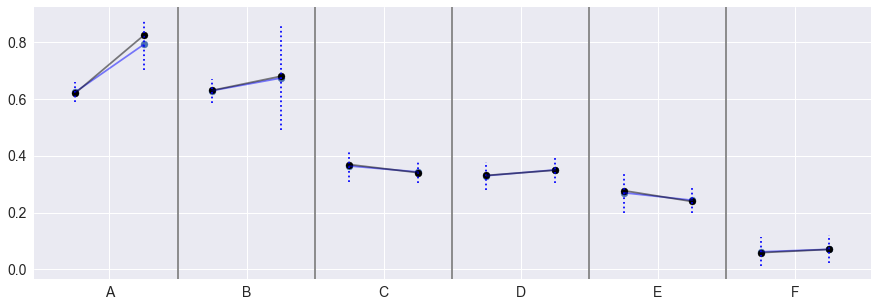

In [126]:
plt.figure(figsize=(15, 5)); plt.scatter(range(len(phat)), phat_fhierarchical); plt.scatter(range(len(phat)), pobs, c='k')
for i, m, se in zip(range(len(phat)), phat_fhierarchical, pstd):
    plt.plot([i,i], [m-2*se, m+2*se], 'b:')
for i in range(0,len(phat)-1,2):
    plt.plot([i,i+1], [phat_fhierarchical[i], phat_fhierarchical[i+1]], 'b', alpha = .5)
for i in range(0,len(phat)-1,2):
    plt.plot([i,i+1], [pobs[i], pobs[i+1]], 'k', alpha = .5)
for xc in x_loc: plt.axvline(x=xc, color = 'gray')
plt.xticks(np.arange(0,12,2)+.5, df.dept.unique());

In [137]:
traces = [pooled_trace, funpooled_trace, unpooled_trace, hierarchical_trace, full_hierarchical_trace]
models = [pooled_model, funpooled_model, unpooled_model, hierarchical, full_hierarchical]
models_list = ['pooled', 'funpooled', 'unpooled', 'var_interc', 'var_intslop']

for t, m, n in zip(traces, models, models_list):
    print '%s  \t : %s' %(n, pm.stats.dic(t,m))

pooled  	 : 869.502334788
funpooled  	 : 170.277132813
unpooled  	 : 125.875383811
var_interc  	 : 138.209627916
var_intslop  	 : 147.006990405


In [138]:
pm.stats.compare(traces, models)

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
1,89.3276,6.05236,0,0.579718,3.44153,0,1
4,89.9712,6.34275,0.643623,0.4202,4.13906,2.24356,1
2,108.116,9.09884,18.788,4.82457e-05,16.2548,16.3682,1
3,108.87,9.68331,19.5426,3.30816e-05,15.8855,15.926,1
0,1000.86,114.821,911.535,6.69614e-199,316.969,317.71,1
